# Reproducing the COHERENT results (21/09/2017)

Code for reproducing the CEvNS signal observed by COHERENT - see [arXiv:1708.01294](https://arxiv.org/abs/1708.01294).


Note that we neglect the axial charge of the nucleus, and thus the contribution from strange quarks. We also use a slightly different parametrisation of the Form Factor, compared to the COHERENT collaboration.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib
#matplotlib.use('Agg')
import matplotlib.pyplot as pl

from scipy.integrate import quad
from scipy.interpolate import interp1d, UnivariateSpline,InterpolatedUnivariateSpline

from scipy.optimize import minimize

from tqdm import tqdm

#Change default font size so you don't need a magnifying glass
matplotlib.rc('font', **{'size'   : 16})

Import the CEvNS module (for calculating the signal spectrum and loading the neutrino fluxes)

In [2]:
import CEvNS
#help(CEvNS.xsec_CEvNS)

### Neutrino Flux @ SNS

Let's load the neutrino flux. Note that here we're only plotting the continuum. There is also a population of monochromatic (29.65 MeV) muon neutrinos which we add in separately in the code (because the flux is a delta-function, it's hard to model here).

/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/scipy/integrate/quadpack.py:356: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


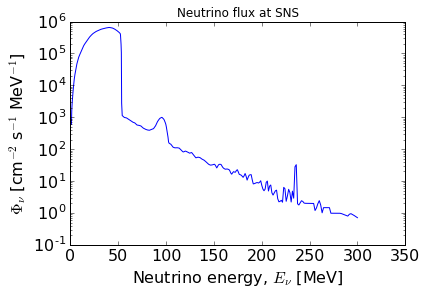

In [3]:
#Initialise neutrino_flux interpolation function
CEvNS.loadNeutrinoFlux("SNS")

#Plot neutrino flux
E_nu = np.logspace(0, np.log10(300),1000)

pl.figure()
pl.semilogy(E_nu, CEvNS.neutrino_flux_tot(E_nu))

pl.title(r"Neutrino flux at SNS", fontsize=12)
pl.xlabel(r"Neutrino energy, $E_\nu$ [MeV]")
pl.ylabel(r"$\Phi_\nu$ [cm$^{-2}$ s$^{-1}$ MeV$^{-1}$]")
pl.show()

### COHERENT efficiency function

Load in the efficiency (as a function of photoelectrons, PE). Set to zero below 5 PE.

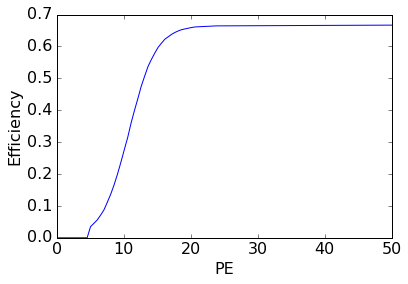

In [4]:
COHERENT_PE, COHERENT_eff = np.loadtxt("DataFiles/COHERENT_eff.txt", unpack=True)
effinterp = interp1d(COHERENT_PE, COHERENT_eff, bounds_error=False, fill_value=0.0)

def efficiency_single(x):
    if (x > 4.9):
        return effinterp(x)
    else:
        return 1e-10
    
efficiency = np.vectorize(efficiency_single)

PEvals = np.linspace(0, 50, 100)
pl.figure()
pl.plot(PEvals, efficiency(PEvals))
pl.xlabel("PE")
pl.ylabel("Efficiency")
pl.show()

### COHERENT event rate

Calculate number of CEvNS signal events at COHERENT (in bins of 2 PE)

In [5]:
#Nuclear properties for Cs and I
A_Cs = 133.0
Z_Cs = 55.0

A_I = 127.0
Z_I = 53.0

#Mass fractions
f_Cs = A_Cs/(A_Cs + A_I)
f_I = A_I/(A_Cs + A_I)

mass = 14.6 #target mass in kg
time = 308.1 #exposure time in days

PEperkeV = 1.17 #Number of PE per keV

#Get the differential rate function from the CEvNS module
#Note that this function allows for an extra vector mediator, 
#but the default coupling is zero, so we'll forget about it
diffRate_CEvNS = CEvNS.differentialRate_CEvNS
    
#Differential rates (times efficiency) for the two target nuclei, per PE
dRdPE_Cs = lambda x: (1.0/PEperkeV)*efficiency(x)*mass*time*f_Cs*diffRate_CEvNS(x/PEperkeV, A_Cs, Z_Cs)
dRdPE_I = lambda x: (1.0/PEperkeV)*efficiency(x)*mass*time*f_I*diffRate_CEvNS(x/PEperkeV, A_I, Z_I)

In [6]:
#Calculate number of events in each bin
PE_bins = np.linspace(0, 50, 26)
dRdPE_bins = np.zeros(25)
bins_Cs = np.zeros(25)
bins_I = np.zeros(25)
for i in tqdm(range(25)):
    bins_Cs[i] = quad(dRdPE_Cs, PE_bins[i], PE_bins[i+1], epsabs = 0.01)[0]
    bins_I[i] = quad(dRdPE_I, PE_bins[i], PE_bins[i+1], epsabs = 0.01)[0]
    dRdPE_bins[i] = bins_Cs[i] + bins_I[i]
    
print "Total CEvNS events expected: ", np.sum(dRdPE_bins)

100%|██████████| 25/25 [00:06<00:00,  4.16it/s]

Total CEvNS events expected:  167.179814235


### Comparing with the COHERENT results

First, let's load in the observed data and calculated spectrum (from [arXiv:1708.01294](https://arxiv.org/abs/1708.01294)).

In [7]:
COHERENT_data = np.loadtxt("DataFiles/COHERENT_data.txt", usecols=(1,))
COHERENT_upper = np.loadtxt("DataFiles/COHERENT_upper.txt", usecols=(1,)) - COHERENT_data
COHERENT_lower = COHERENT_data - np.loadtxt("DataFiles/COHERENT_lower.txt", usecols=(1,))
COHERENT_spect = np.loadtxt("DataFiles/COHERENT_spectrum.txt", usecols=(1,))
COHERENT_bins = np.arange(1,50,2)

Now plot the results:

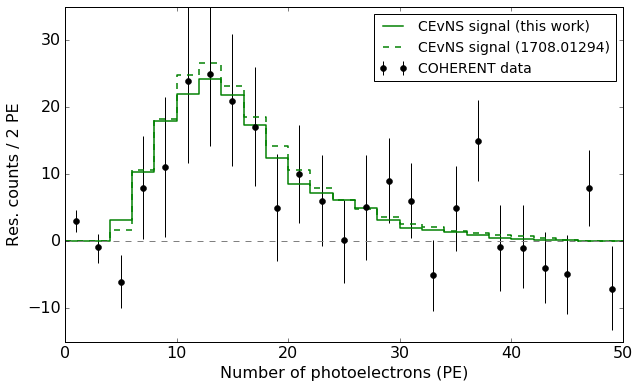

In [8]:
pl.figure(figsize=(10,6))

pl.step(PE_bins, np.append(dRdPE_bins,0), 'g', linestyle="-", where = "post", label="CEvNS signal (this work)",linewidth=1.5)
pl.step(PE_bins, np.append(COHERENT_spect,0), 'g', linestyle="--", where = "post", label="CEvNS signal (1708.01294)",linewidth=1.5)

pl.axhline(0, linestyle='--', color = 'gray')

pl.errorbar(COHERENT_bins, COHERENT_data, fmt='ko', \
            yerr = [COHERENT_lower, COHERENT_upper], label="COHERENT data",\
            capsize=0.0)

pl.xlabel("Number of photoelectrons (PE)")
pl.ylabel("Res. counts / 2 PE")

pl.legend( fontsize=14)

pl.xlim(0, 50)
pl.ylim(-15, 35)

pl.savefig("plots/COHERENT_data.pdf", bbox_inches="tight")
pl.show()

## Fit to signal strength

Very simple fit to the number of CEvNS signal events

In [9]:
def chisq_CEvNS(Nsig):
    mu = Nsig/np.sum(dRdPE_bins)
    sig = dRdPE_bins*mu
    BG = 6.0/25 #neutron BG per bin
    return np.sum((COHERENT_data - (sig + BG))**2/COHERENT_upper**2)

def chisq_full(Nsig, a, b):
    Nobs = 142
    Bon = 6
    sig_stat = 30.95
    sig_a = 0.28
    sig_b = 0.25
    
    return (Nobs - Nsig*(1+a)-Bon*(1+b))**2/(sig_stat**2) + (a/sig_a)**2 + (b/sig_b)**2

def chisq_CEvNS2(Nsig):
    return minimize(lambda x: chisq_full(Nsig, x[0], x[1]), (0.0,0.0)).fun

In [10]:
Nsiglist= np.linspace(0, 300,1001)
chilist = [chisq_CEvNS2(Ns) for Ns in Nsiglist]

delta_chi2 = (chilist - np.min(chilist))

print Nsiglist[np.argmin(delta_chi2)]
print Nsiglist[delta_chi2 < 0.5]

135.9
[ 105.9  106.2  106.5  106.8  107.1  107.4  107.7  108.   108.3  108.6
  108.9  109.2  109.5  109.8  110.1  110.4  110.7  111.   111.3  111.6
  111.9  112.2  112.5  112.8  113.1  113.4  113.7  114.   114.3  114.6
  114.9  115.2  115.5  115.8  116.1  116.4  116.7  117.   117.3  117.6
  117.9  118.2  118.5  118.8  119.1  119.4  119.7  120.   120.3  120.6
  120.9  121.2  121.5  121.8  122.1  122.4  122.7  123.   123.3  123.6
  123.9  124.2  124.5  124.8  125.1  125.4  125.7  126.   126.3  126.6
  126.9  127.2  127.5  127.8  128.1  128.4  128.7  129.   129.3  129.6
  129.9  130.2  130.5  130.8  131.1  131.4  131.7  132.   132.3  132.6
  132.9  133.2  133.5  133.8  134.1  134.4  134.7  135.   135.3  135.6
  135.9  136.2  136.5  136.8  137.1  137.4  137.7  138.   138.3  138.6
  138.9  139.2  139.5  139.8  140.1  140.4  140.7  141.   141.3  141.6
  141.9  142.2  142.5  142.8  143.1  143.4  143.7  144.   144.3  144.6
  144.9  145.2  145.5  145.8  146.1  146.4  146.7  147.   147.3  147.6


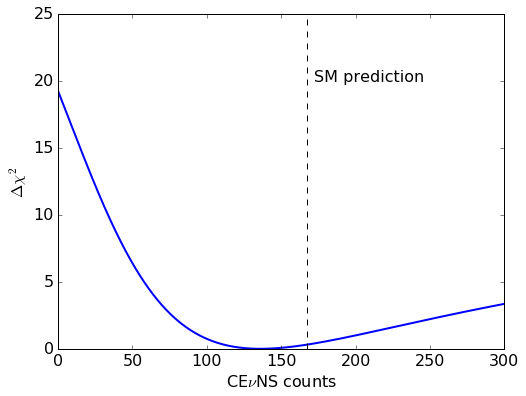

In [11]:
pl.figure(figsize=(8,6))
pl.plot(Nsiglist, delta_chi2, linewidth=2.0)
pl.ylim(0, 25)

pl.axvline(np.sum(dRdPE_bins), linestyle='--', color='k')
pl.text(172, 20, "SM prediction")

pl.ylabel(r"$\Delta \chi^2$")
pl.xlabel(r"CE$\nu$NS counts")

pl.savefig("plots/COHERENT_likelihood.pdf", bbox_inches="tight")

pl.show()

## NSI constraints

Calculate constraints on NSI parameters. Here, we're just assuming that the flavor-conserving e-e NSI couplings are non-zero, so we have to calculate the contribution to the rate from only the electron neutrinos and then see how that changes:

In [12]:
#Differential rates (times efficiency) for the two target nuclei, per PE 
# For electron neutrinos ONLY
dRdPE_Cs_e = lambda x: (1.0/PEperkeV)*efficiency(x)*mass*time*f_Cs*diffRate_CEvNS(x/PEperkeV, A_Cs, Z_Cs, nu_flavor="e")
dRdPE_I_e = lambda x: (1.0/PEperkeV)*efficiency(x)*mass*time*f_I*diffRate_CEvNS(x/PEperkeV, A_I, Z_I, nu_flavor="e")

#Now calculate bin-by-bin signal from electron neutrinos
bins_Cs_e = np.zeros(25)
bins_I_e = np.zeros(25)
for i in tqdm(range(25)):
    bins_Cs_e[i] = quad(dRdPE_Cs_e, PE_bins[i], PE_bins[i+1], epsabs = 0.01)[0]
    bins_I_e[i] = quad(dRdPE_I_e, PE_bins[i], PE_bins[i+1], epsabs = 0.01)[0]

print "Number of CEvNS events due to nu_e: ", np.sum(bins_Cs_e + bins_I_e)

100%|██████████| 25/25 [00:06<00:00,  7.17it/s]

Number of CEvNS events due to nu_e:  86.3440584916


Now, let's calculate the correction to the CEvNS rate from flavor-conserving NSI:

In [13]:
def NSI_corr(eps_uV, eps_dV, A, Z):
    SIN2THETAW = 0.2387
    
    #Calculate standard weak nuclear charge (squared)
    Qsq = 4.0*((A - Z)*(-0.5) + Z*(0.5 - 2*SIN2THETAW))**2
    
    #Calculate the modified nuclear charge from NSI
    Qsq_NSI = 4.0*((A - Z)*(-0.5 + eps_uV + 2.0*eps_dV) + Z*(0.5 - 2*SIN2THETAW + 2*eps_uV + eps_dV))**2
    
    return Qsq_NSI/Qsq

Calculate simplified (single bin) chi-squared (see chi-squared expression around p.32 in COHERENT paper):

In [14]:
def chisq_NSI_simple(eps_uV, eps_dV, alpha, beta):
    #NB: bins_I and bins_Cs are calculated further up in the script (they are the SM signal prediction)
    
    #Beam-on backgrounds
    N_BG = 6.0
    #Number of measured events
    N_meas = 142.0 
    #Statistical uncertainty
    sig_stat = np.sqrt(N_meas + 2*405 + N_BG) 
    #Signal events from Iodine (with NSI correction only applying to electron neutrino events)
    N_sig_I = (bins_I + (NSI_corr(eps_uV, eps_dV, A_I, Z_I) - 1.0)*bins_I_e)
    #Now signal events from Caesium
    N_sig_Cs = (bins_Cs + (NSI_corr(eps_uV, eps_dV, A_Cs, Z_Cs) - 1.0)*bins_Cs_e)
    
    #Number of signal events
    N_NSI = np.sum(N_sig_I + N_sig_Cs)
    
    #Uncertainties
    unc = (alpha/0.28)**2 + (beta/0.25)**2
    
    return ((N_meas - N_NSI*(1.0+alpha) - N_BG*(1.0+beta))**2)/sig_stat**2 + unc

Also consider a bin-by-bin chi-squared:

In [15]:
def chisq_NSI(eps_uV, eps_dV, alpha, beta):
    #NB: bins_I and bins_Cs are calculated further up in the script (they are the SM signal prediction)
    
    #Beam-on background per bin (roughly)
    N_BG = 6.0/25.0
    
    #Signal events from Iodine (with NSI correction only applying to electron neutrino events)
    N_sig_I = (bins_I + (NSI_corr(eps_uV, eps_dV, A_I, Z_I) - 1.0)*bins_I_e)
    #Now signal events from Caesium
    N_sig_Cs = (bins_Cs + (NSI_corr(eps_uV, eps_dV, A_Cs, Z_Cs) - 1.0)*bins_Cs_e)
    #Number of bin-by-bin signal events
    N_NSI_bins = N_sig_I + N_sig+Cs
    
    #Uncertainties
    unc = (alpha/0.28)**2 + (beta/0.25)**2
    
    return np.sum((COHERENT_data - N_NSI_bins*(1.0 + alpha) - N_BG*(1.0 + beta))**2/COHERENT_upper**2) + unc

Calculate the (minimum) chi-squared on a grid

In [16]:
Ngrid = 101

ulist = np.linspace(-1.0, 1.0, Ngrid)
dlist = np.linspace(-1.0, 1.0, Ngrid)
UL, DL = np.meshgrid(ulist, dlist)
chigrid = 0.0*UL

minchi2 = 1e30
BF = [0,0]

#Not very elegant loop
for i in tqdm(range(Ngrid)):
    for j in range(Ngrid):
        #Minimise over alpha and beta for each grid point
        chigrid[i,j] = minimize(lambda x: chisq_NSI_simple(UL[i,j], DL[i,j], x[0], x[1]), (0.0,0.0)).fun
        if (chigrid[i,j] < minchi2):
            minchi2 = chigrid[i,j]
            BF = (UL[i,j], DL[i,j])
            
print "Best fit point: ", BF
delta_chi2_grid = chigrid - np.min(chigrid)
np.savetxt("results/COHERENT_NSI_deltachi2.txt", delta_chi2_grid, header="101x101 grid, corresponding to (uV, dV) values between -1 and 1.")

100%|██████████| 101/101 [00:08<00:00, 12.12it/s]

Best fit point:  (-0.76000000000000001, 1.0)


Plot the 90% allowed regions:

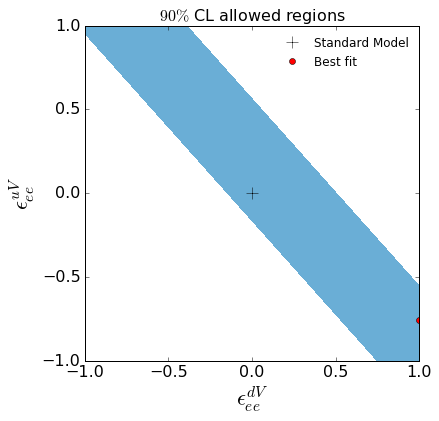

In [17]:
pl.figure(figsize=(6,6))
#pl.contourf(DL, UL, delta_chi2_grid, levels=[0,1,2,3,4,5,6,7,8,9,10],cmap="Blues")
pl.contourf(DL, UL, delta_chi2_grid, levels=[0,4.6],cmap="Blues")
#levels=[0,4.60]
#pl.colorbar()

pl.plot(0.0, 0.0,'k+', markersize=12.0, label="Standard Model")

pl.plot(BF[1], BF[0], 'ro', label="Best fit")
#pl.plot(-0.25, 0.5, 'ro')

pl.ylabel(r"$\epsilon_{ee}^{uV}$", fontsize=22.0)
pl.xlabel(r"$\epsilon_{ee}^{dV}$" ,fontsize=22.0)

pl.title(r"$90\%$ CL allowed regions", fontsize=16.0)

pl.legend(frameon=False, fontsize=12, numpoints=1)

pl.savefig("plots/COHERENT_NSI.pdf", bbox_inches="tight")
pl.show()

## Limits on the neutrino magnetic moment

Now let's calculate a limit on the neutrino magnetic moment (again, from a crude single-bin $\chi^2$).

In [18]:
#Calculate the number of neutrino magnetic moment scattering events
#assuming a universal magnetic moment (in units of 1e-12 mu_B)

diffRate_mag = np.vectorize(CEvNS.differentialRate_magnetic)

dRdPE_mag = lambda x: (1.0/PEperkeV)*efficiency(x)*mass*time*(f_Cs*diffRate_mag(x/PEperkeV, A_Cs, Z_Cs, 1e-12)\
                                                              + f_I*diffRate_mag(x/PEperkeV, A_I, Z_I, 1e-12))
N_mag = quad(dRdPE_mag, 0, 50)[0]
print "Number of magnetic moment signal events (for mu_nu = 1e-12 mu_B):", N_mag

Number of magnetic moment signal events (for mu_nu = 1e-12 mu_B): 9.23904377448e-06


In [19]:
def chisq_mag(mu_nu, alpha, beta):    
    #Beam-on backgrounds
    N_BG = 6.0
    #Number of measured events
    N_meas = 142.0 
    #Statistical uncertainty
    sig_stat = np.sqrt(N_meas + 2*405 + N_BG) 
    
    #Signal events is sum of standard CEvNS + magnetic moment events
    N_sig = np.sum(dRdPE_bins) + N_mag*(mu_nu/1e-12)**2
    
    
    #Uncertainties
    unc = (alpha/0.28)**2 + (beta/0.25)**2
    
    return ((N_meas - N_sig*(1.0+alpha) - N_BG*(1.0+beta))**2)/sig_stat**2 + unc

Scan over a grid:

In [20]:
Ngrid = 501

maglist = np.logspace(-12, -6, Ngrid)

minchi2 = 1e30
BF = 0.0

chi2_list = 0.0*maglist
#Not very elegant loop
for i in tqdm(range(Ngrid)):
    #Minimise over alpha and beta for each grid point
    chi2_list[i] = minimize(lambda x: chisq_mag(maglist[i], x[0], x[1]), (0.0,0.0)).fun
    if (chi2_list[i] < minchi2):
        minchi2 = chi2_list[i]
        BF = maglist[i]
            
delta_chi2 = chi2_list - np.min(chi2_list)

upper_limit = maglist[delta_chi2 > 2.706][0]

print "90% upper limit: ", upper_limit

100%|██████████| 501/501 [00:00<00:00, 672.12it/s] 

90% upper limit:  3.56451133426e-09


Do some plotting:

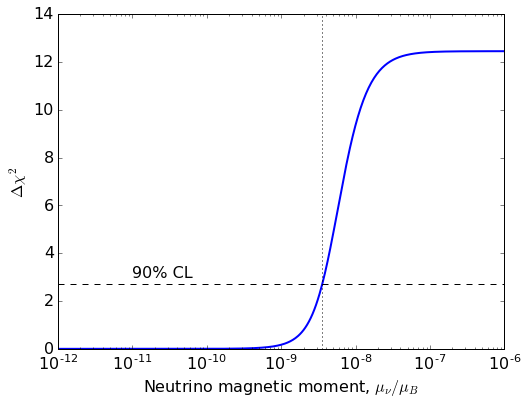

In [21]:
pl.figure(figsize=(8,6))
pl.semilogx(maglist, delta_chi2, linewidth=2.0)
#pl.ylim(0, 25)

pl.axhline(2.706, linestyle='--', color='k')
pl.axvline(upper_limit, linestyle=':', color='k')

pl.text(1e-11, 3, "90% CL")

pl.ylabel(r"$\Delta \chi^2$")
pl.xlabel(r"Neutrino magnetic moment, $\mu_{\nu} / \mu_B$")

pl.savefig("plots/COHERENT_magnetic.pdf", bbox_inches="tight")

pl.show()

## Limits on new vector mediators

First, let's calculate the total number of signal events at a given mediator mass and coupling...

It takes a while to recalculate the number of signal events for each mediator mass and coupling, so we'll do some rescaling and interpolation trickery:

In [22]:
def tabulate_rate( m_med):
    vector_rate = lambda x, gsq: (1.0/PEperkeV)*efficiency(x)*mass*time*(f_Cs*CEvNS.differentialRate_CEvNS(x/PEperkeV, A_Cs, Z_Cs,gsq,m_med)\
                                                              + f_I*CEvNS.differentialRate_CEvNS(x/PEperkeV, A_I, Z_I, gsq,m_med))
    alpha = 1.0
    
    PE_min = 4.0
    PE_max = 50.0
    Nvals = 500
    PEvals = np.logspace(np.log10(PE_min), np.log10(PE_max),Nvals)
    
    Rvals_A = [np.sqrt(vector_rate(PEvals[i], 0)) for i in range(Nvals)]
    Rvals_B = [(1.0/(4.0*alpha*Rvals_A[i]))*(vector_rate(PEvals[i], alpha) - vector_rate(PEvals[i], -alpha)) for i in range(Nvals)]
    
    tabrate_A = InterpolatedUnivariateSpline(PEvals, Rvals_A, k = 1)
    tabrate_B = InterpolatedUnivariateSpline(PEvals, Rvals_B, k = 1)
    
    return tabrate_A, tabrate_B

In [23]:
def N_sig_vector(gsq, m_med):
    integrand = lambda x: (1.0/PEperkeV)*efficiency(x)*mass*time*(f_Cs*CEvNS.differentialRate_CEvNS(x/PEperkeV, A_Cs, Z_Cs,gsq,m_med)\
                                                              + f_I*CEvNS.differentialRate_CEvNS(x/PEperkeV, A_I, Z_I, gsq,m_med))

    return quad(integrand, 4.0, 50, epsabs=0.01)[0]

def N_sig_vector_tab(gsq, tabrate_A, tabrate_B):
    integrand = lambda x: (tabrate_A(x) + tabrate_B(x)*gsq)**2.0
    return quad(integrand, 4.0, 50, epsabs=0.01)[0]

In [24]:
def tabulate_Nsig(tabrate_A, tabrate_B):
    N_A = N_sig_vector_tab(0, tabrate_A, tabrate_B)
    N_C = 0.5*(N_sig_vector_tab(1.0, tabrate_A, tabrate_B) + N_sig_vector_tab(-1.0, tabrate_A, tabrate_B))- N_A
    N_B = N_sig_vector_tab(1.0, tabrate_A, tabrate_B) - N_A - N_C
    return N_A, N_B, N_C

In [25]:
def N_sig_fulltab(gsq, Nsig_A, Nsig_B, Nsig_C):
    return Nsig_A + gsq*Nsig_B + gsq**2*Nsig_C

In [26]:
%timeit N_sig_vector(1e-4, 1000)

1 loop, best of 3: 6.29 s per loop


In [27]:
print 
rate_A, rate_B = tabulate_rate(1000)
N_A, N_B,N_C = tabulate_Nsig(rate_A, rate_B)
#N_sig_vector_tab(1e-4, rate_A, rate_B)
N_sig_fulltab(1e-4, N_A, N_B, N_C)

665048.4593646104

Now calculate the $\chi^2$ (use a generic form, so that we don't have to recalculate the number of signal events all the time...):

In [91]:
def chisq_generic(N_sig, alpha, beta):   
    
    #Beam-on backgrounds
    N_BG = 6.0
    #Number of measured events
    N_meas = 142.0 
    #Statistical uncertainty
    sig_stat = np.sqrt(N_meas + 2*405 + N_BG) 
    
    #Uncertainties
    unc = (alpha/0.28)**2 + (beta/0.25)**2
    
    return ((N_meas - N_sig*(1.0+alpha) - N_BG*(1.0+beta))**2)/sig_stat**2 + unc

In [92]:
gsq_list = np.append(np.logspace(0, 2, 100),1e20)
m_list = np.sort(np.append(np.logspace(-2, 4,49), [1e-6,1e8]))

#print gsq_list
                   
g_upper = 1e-11*(50**2+m_list**2)
g_lower = 1e-13*(50**2+m_list**2)

chi2_vec_grid = np.zeros((51, 101))

for i in tqdm(range(len(m_list))):
    rate_A, rate_B = tabulate_rate(m_list[i])
    N_A, N_B,N_C = tabulate_Nsig(rate_A, rate_B)
    for j, gsq in enumerate(gsq_list):
        #N_sig = N_sig_vector_tab(gsq, rate_A, rate_B)
        N_sig = N_sig_fulltab(gsq*g_lower[i], N_A, N_B, N_C)
        chi2_vec_grid[i, j] = minimize(lambda x: chisq_generic(N_sig, x[0], x[1]), (0.0,0.0), method="CG").fun

100%|██████████| 51/51 [04:05<00:00,  4.87s/it]


(51, 101)


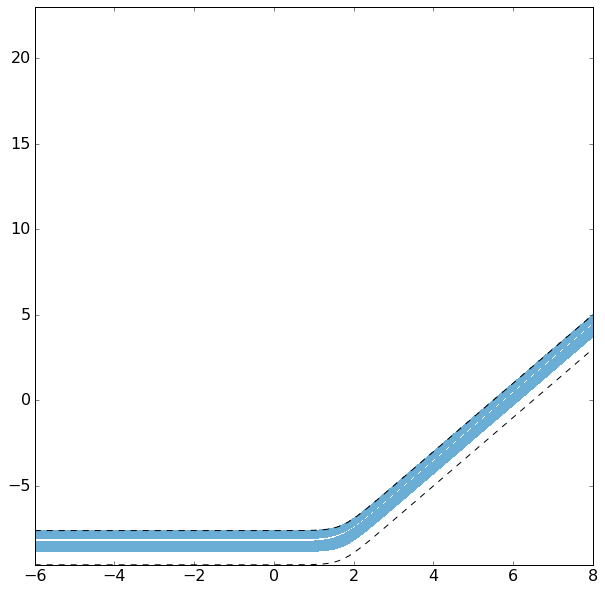

In [93]:
delta_chi2_vec = chi2_vec_grid - np.min(chi2_vec_grid)

mgrid, ggrid = np.meshgrid(m_list, gsq_list, indexing='ij')
ggrid *= 1e-13*(50**2 + mgrid**2)

print delta_chi2_vec.shape

np.savetxt("results/COHERENT_Zprime.txt", np.c_[mgrid.flatten(), ggrid.flatten(), delta_chi2_vec.flatten()])

pl.figure(figsize=(10,10))
pl.contourf(np.log10(mgrid), np.log10(ggrid), delta_chi2_vec, levels=[2.7,1e10],cmap="Blues")
pl.plot(np.log10(m_list), np.log10(g_upper), 'k--')
pl.plot(np.log10(m_list), np.log10(g_lower), 'k--')
#pl.colorbar()
pl.show()

# Limits on a new scalar mediator

In [61]:
def calc_Nsig_scalar( m_med):
    scalar_rate = lambda x: (1.0/PEperkeV)*efficiency(x)*mass*time*(f_Cs*CEvNS.differentialRate_scalar(x/PEperkeV, A_Cs, Z_Cs,1,m_med)\
                                                              + f_I*CEvNS.differentialRate_scalar(x/PEperkeV, A_I, Z_I, 1,m_med))
    alpha = 1.0
    
    PE_min = 4.0
    PE_max = 50.0
    
    return quad(scalar_rate, PE_min, PE_max)[0]

In [62]:
print calc_Nsig_scalar(1e-3)

2.84451052113e+20


In [88]:
m_list = np.logspace(-3, 7,50)
gsq_list = np.logspace(0, 4, 50)

g_upper = 1e-10*(50**2+m_list**2)
g_lower = 1e-14*(50**2+m_list**2)

chi2_scal_grid = np.zeros((len(m_list), len(gsq_list)))

#SM prediction for number of signal events: 172
Nsig_SM = 172.0

for i in tqdm(range(len(m_list))):
    Nsig_scalar = calc_Nsig_scalar(m_list[i])
    for j in range(len(gsq_list)):
        chi2_scal_grid[i,j] = minimize(lambda x: chisq_generic(Nsig_SM + Nsig_scalar*(gsq_list[j]*g_lower[i])**2, x[0], x[1]), (0.0,0.0), method="CG").fun
    

100%|██████████| 50/50 [05:31<00:00,  6.73s/it]


(50, 50)


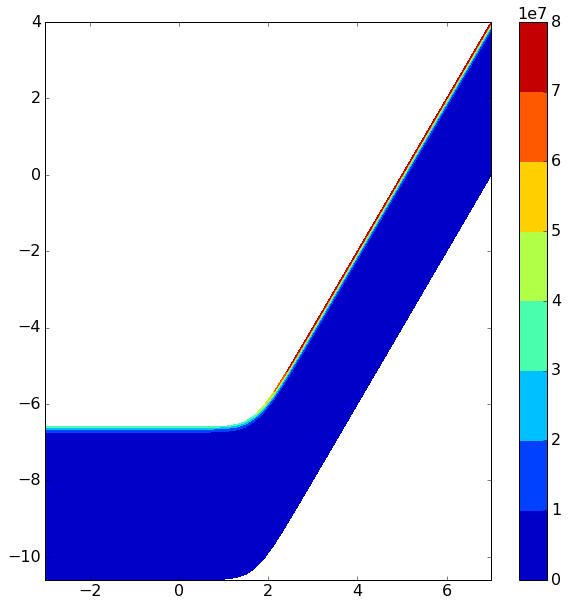

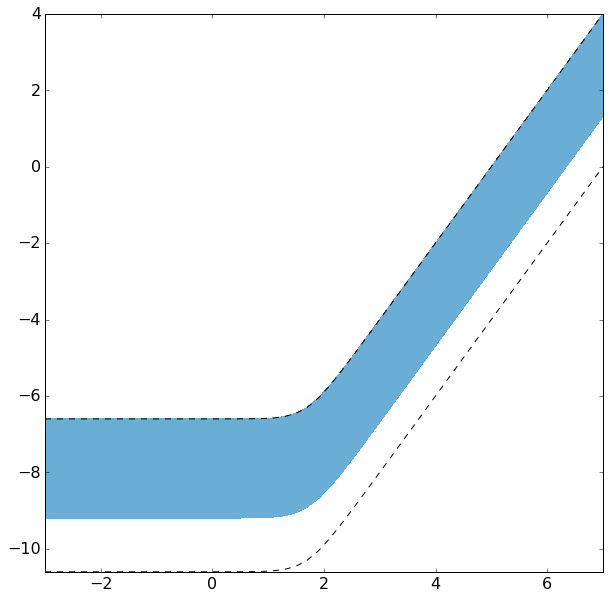

In [89]:
delta_chi2_scal = chi2_scal_grid - np.min(chi2_scal_grid)

mgrid, ggrid = np.meshgrid(m_list, gsq_list, indexing='ij')
ggrid *= 1e-14*(50**2+mgrid**2)

print delta_chi2_scal.shape

np.savetxt("results/COHERENT_scalar.txt", np.c_[mgrid.flatten(), ggrid.flatten(), delta_chi2_scal.flatten()])

pl.figure(figsize=(10,10))
pl.contourf(np.log10(mgrid), np.log10(ggrid),delta_chi2_scal)
pl.colorbar()
pl.show()

pl.figure(figsize=(10,10))
pl.contourf(np.log10(mgrid), np.log10(ggrid), delta_chi2_scal, levels=[2.7,1e30],cmap="Blues")
pl.plot(np.log10(m_list), np.log10(g_upper), 'k--')
pl.plot(np.log10(m_list), np.log10(g_lower), 'k--')
#pl.colorbar()
pl.show()